In [ ]:
# Rotation Thrust Analysis

Analysis leading up to the rotation thrust experimental days. Goals include

1. Determine feasability of localized NTV within DIII-D given the current coils.
2. Determine sensitivity to omega_E zero crossing.

## Notebook Settings

In [63]:
%pylab notebook

import sys
if '/p/gpec/users/nlogan/gpec' not in sys.path:
    sys.path.append('/p/gpec/users/nlogan/gpec')
from pypec import data,gpec,post

import seaborn
seaborn.set_palette('colorblind')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Shot 163113

The kinetic EFIT gfile for this shot was supplied by Colin Chrystal. He and Brian like this shot because they get accurate transport modeling with TGLF.

There was some discussion as to wether or not we should include the fast ions in the ion density profile. I believe I opted for the profile without, although Colin supplied both.

There were some unit conversions required between Colin's profile table and the correct PENT inputs. See below.


### Prep

In [27]:
def kinetic_file_formatter(pfile='g163113.03600_profiles.txt', kdir='/p/gpec/users/nlogan/data/d3d/kinetics'):
    """
    Convert Colin ascii tables to pent files format.

    :param gfile:
    :param kdir:
    :return:

    """
    # variables
    kdir = kdir.rstrip('/') + '/'

    # name and unit conversions
    ynames = ['ni(m^-3)', 'ne(m^-3)', 'ti(eV)', 'te(eV)', 'omega_E(rad/s)']
    onames = ['ni_thcm^3', 'necm^3', "TikeV", "TekeV", "w_EXBkHz"]
    convrt = [1e6, 1e6, 1e3, 1e3, 2*np.pi*1e3]

    okin = data.read(kdir + pfile, squeeze=True)
    # convert to pent units
    for y, o, c in zip(ynames, onames, convrt):
        okin.y[y] = okin.y[o] * c
    data.write(okin, fname=kdir + pfile.replace('.txt', '_PENTformat.txt'), ynames=ynames)
    okin.plot1d(ynames)
    okin.plot1d(onames)

    return True

Casting table 1 into Data object.


<IPython.core.display.Javascript object>


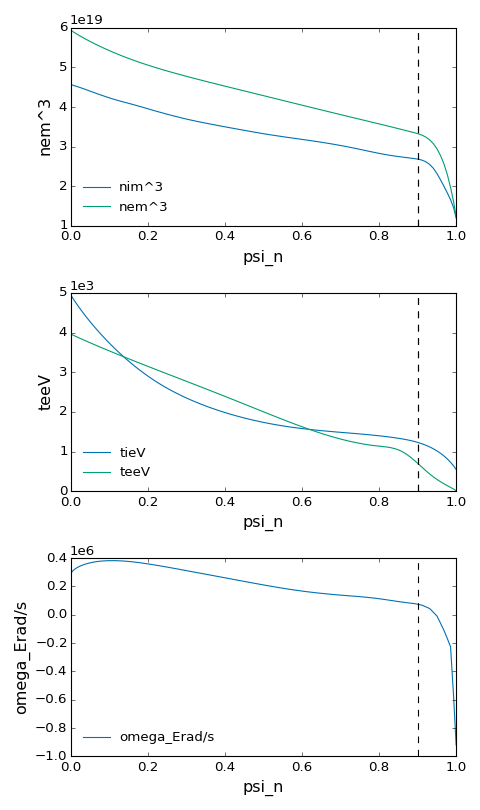

In [4]:
kin163113 = data.open_dataset('/p/gpec/users/nlogan/data/d3d/kinetics/g163113.03600_profiles_PENTformat.txt')
f,ax = data.plt.subplots(3)
for k in kin163113.data_vars.keys():
    if k.startswith('n'):
        a = ax[0]
    elif k.lower().startswith('t'):
        a = ax[1]
    else:
        a = ax[2]
    kin163113[k].plot(ax=a,label=k)
    a.axvline(x=0.9,linestyle='--',color='k')
    a.legend()

### Analysis

First, we read the netcdf gpec results

In [7]:
root = '/p/gpec/users/nlogan/data/d3d/2016_rotationthrust/g163113.03600/'
con = data.open_dataset(root+'gpec_control_output_n2.nc')
prof = data.open_dataset(root+'gpec_profile_output_n2.nc')
cyl = data.open_dataset(root+'gpec_cylindrical_output_n2.nc')

The first thing we will look at is the self-consistent torque matrices, which relate the spectrum on the plasma control surface to the integral torque inside a given flux surface. 

The matrices show the torque is primarily from mid-m near m >~ q_lim = 6.6. Note this is not the pitch resonance m = nq_lim ~ 13.

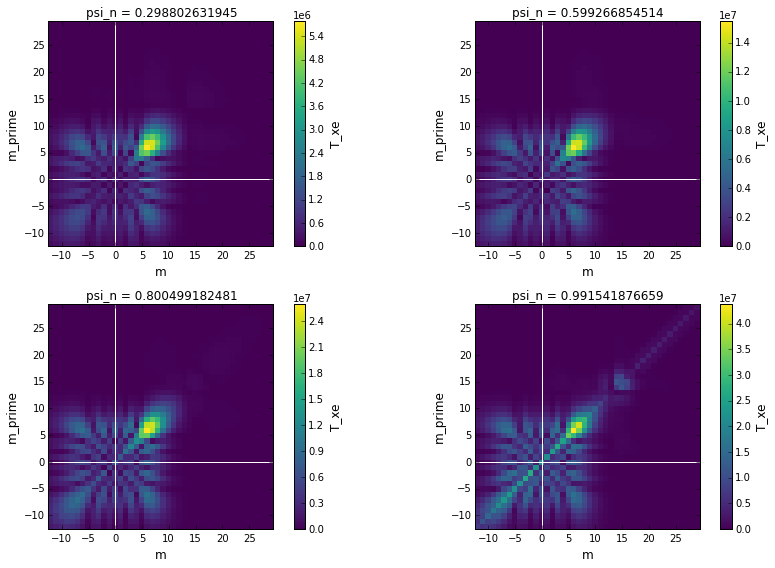

In [46]:
f,ax = data.plt.subplots(2,2,subplot_kw={'aspect':'equal'})
for i,psi in enumerate([0.3,0.6,0.8,1.0]):
    np.abs(prof['T_xe'].sel(psi_n=psi,method='nearest')).plot(ax=ax.flat[i])
    ax.flat[i].axvline(0,color='w')
    ax.flat[i].axhline(0,color='w')

Notice that all the matrices look qualitatively similar to the eye. In order to optimize localized torque, we must utilize the subtle differences between the matrices at differing radii. Luckily, there are additional differences in the complex phase of the matrix components.

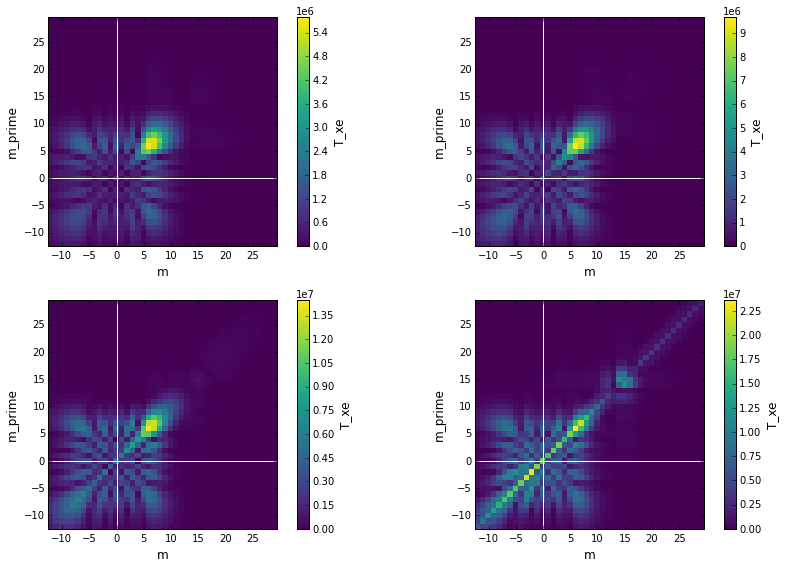

In [48]:
f,ax = data.plt.subplots(2,2,subplot_kw={'aspect':'equal'})
for i,psi in enumerate([0.3,0.6,0.8,1.0]):
    Delta = prof['T_xe'].sel(psi_n=psi,method='nearest') - prof['T_xe'].sel(psi_n=psi-0.3,method='nearest')
    np.abs(Delta).plot(ax=ax.flat[i])
    ax.flat[i].axvline(0,color='w')
    ax.flat[i].axhline(0,color='w')

These differences can create the following torque profiles. Note the profiles are normalized to the input external-flux energy.

<IPython.core.display.Javascript object>


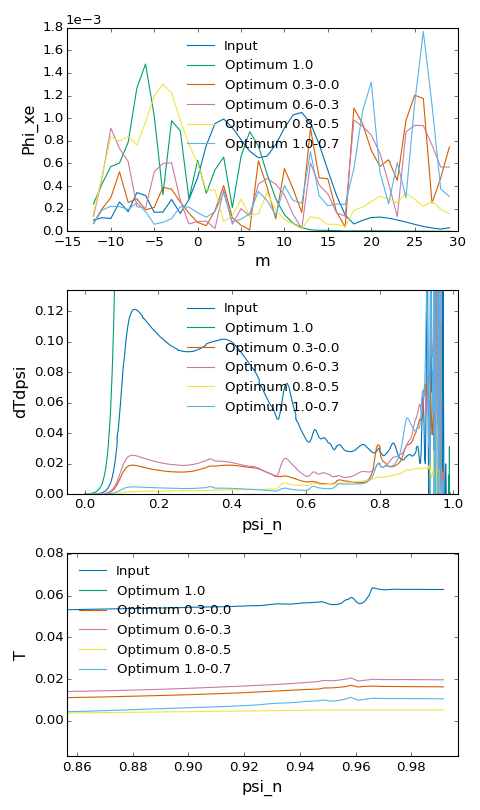

In [12]:
f,ax = data.plt.subplots(3)

input_power = np.dot(con['Phi_xe'].conj(), con['Phi_xe']).real 
T_mat = prof['T_xe'].transpose('psi_n', 'm_prime', 'm') # order matters in  dot products
T_mat = (T_mat + T_mat.T.conj())/2. # Hermitian cleanup
T_mat /= sqrt(con.attrs['area']) # area norm is bug in 1.0.1

# coil input result
l = np.abs(con['Phi_xe']).plot(ax=ax[0], label='Input')
prof['dTdpsi_n'] = prof['dTdpsi']*0 + np.gradient(prof['T'])
l = prof['dTdpsi'].real.plot(ax=ax[1], label='Input')
l = prof['T'].real.plot(ax=ax[2], label='Input')

# total torque optimum 
w,v = post.optimize_torque(prof['T_xe'],psihigh=1.0)
T_opt = np.real(np.dot(np.dot(v.T.conj(), T_mat), v))/2
l, = ax[0].plot(con['m'], np.abs(v) * np.sqrt(input_power), label='Optimum 1.0')
l, = ax[1].plot(prof['psi_n'], np.gradient(T_opt*input_power)/np.gradient(prof['psi_n']), label='Optimum 1.0')
l, = ax[2].plot(prof['psi_n'], T_opt*input_power, label='Optimum 1.0')

# localized torque optima
for i,psi in enumerate([0.3,0.6,0.8,1.0]):
    w,v = post.optimize_torque(prof['T_xe'],psilow=psi-0.3,psihigh=psi, normalize=True)
    T_opt = np.real(np.dot(np.dot(v.T.conj(), T_mat), v))/2
    l, = ax[0].plot(con['m'], np.abs(v) * np.sqrt(input_power), label='Optimum {:}-{:}'.format(psi,psi-0.3))
    l, = ax[1].plot(prof['psi_n'], np.gradient(T_opt*input_power)/np.gradient(prof['psi_n']), label='Optimum {:}-{:}'.format(psi,psi-0.3))
    l, = ax[2].plot(prof['psi_n'], T_opt*input_power, label='Optimum {:}-{:}'.format(psi,psi-0.3))

for a in ax:
    a.legend()

So this actually doesn't look very promissing. We see the "localized" torque densities are not very peaked, and that their total torques are an order of magnitude below the simple aligned coils or 2 orders of magnitude below the global maximum.

---

> NOTE: The local optima *without* normalization give larger torques than the total optimum. **This indicates a bug!!**

---

With the full spectral control not providing cleanly localized torques, I do not expect the coils have much wiggle room at all. Lets se what they can do,

<IPython.core.display.Javascript object>


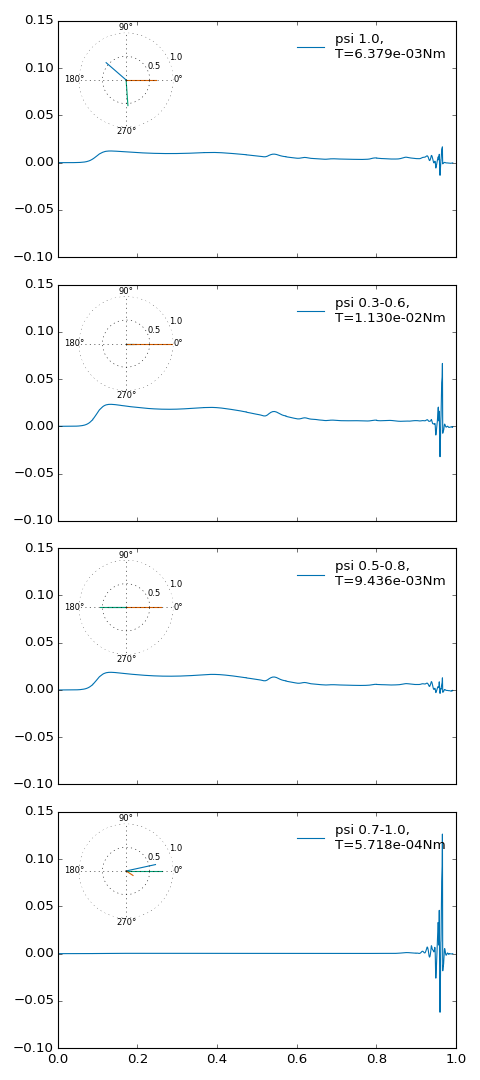


psi 0.3-0.6, T=1.130e-02Nm
coil     amp      ang     
0        0.21     -1.197e-13
1        0.15     -9.263e-14
2        0.97     +0.00000

psi 0.5-0.8, T=9.436e-03Nm
coil     amp      ang     
0        0.38     -180.000
1        0.56     +180.000
2        0.74     +0.00000

psi 0.7-1.0, T=5.718e-04Nm
coil     amp      ang     
0        0.64     +12.2600
1        0.75     +0.00000
2        0.17     -32.9800


In [64]:
f,ax = data.plt.subplots(4, sharex=True, sharey=True)
plt.draw() # drawing updates that axes positions with autolayout

def insert_polar(ax,rect):
    """Inset a polar axis in the parent axes"""
    #ina = mpl_toolkits.axes_grid.inset_locator.inset_axes(ax[0], width="30%", height="30%",loc=3, axes_kwargs={'polar':True})
    #ina = ax.get_figure().add_axes(rect, polar=True, transform=ax.get_transform()) # left, bottom, width, height
    ina = data.plt.add_inset_axes(ax,rect,polar=True)
    ina.set_xticks([0,pi/2,pi,3*pi/2]) #([0,90,180,270])
    #ina.set_xticklabels(['0','','180',''])
    #ina.yaxis.set_major_locator(plt.MaxNLocator(3))
    ina.set_yticks([0.5,1,1.5,2])
    ina.set_ylim(0,1)
    ina.spines['polar'].set_visible(False)
    return ina

T_coil = prof['T_coil'].transpose('psi_n', 'coil_index_prime', 'coil_index') # order matters in  dot products
T_coil = (T_coil + T_coil.T.conj())/2. # Hermitian cleanup
T_coil /= sqrt(con.attrs['area']) # area norm is bug in 1.0.1

# total torque optimum 
w,v = post.optimize_torque(prof['T_coil'],psihigh=1.0)
T_opt = np.real(np.dot(np.dot(v.T.conj(), T_coil), v))/2
l, = ax[0].plot(prof['psi_n'], np.gradient(T_opt)/np.gradient(prof['psi_n']), label='psi 1.0, \nT={:.3e}Nm'.format(T_opt[-1]))
ina = insert_polar(ax[0],[0.01, 0.55, 0.4, 0.4])
for i in range(3):
    l, = ina.plot([np.angle(v[i])]*2,[0,np.abs(v[i])])

# localized torque optima
for ai,psi in enumerate([0.6,0.8,1.0]):
    w,v = post.optimize_torque(prof['T_coil'],psilow=psi-0.3,psihigh=psi, normalize=True)
    T_opt = np.real(np.dot(np.dot(v.T.conj(), T_coil), v))/2
    l, = ax[ai+1].plot(prof['psi_n'], np.gradient(T_opt)/np.gradient(prof['psi_n']), label='psi {:}-{:}, \nT={:.3e}Nm'.format(psi-0.3,psi,T_opt[-1]))
    ina = insert_polar(ax[ai+1],[0.01, 0.55, 0.4, 0.4])
    print('\npsi {:}-{:}, T={:.3e}Nm'.format(psi-0.3,psi,T_opt[-1]))
    print('{:8} {:8} {:8}'.format('coil','amp','ang'))
    for i in range(3):
        l, = ina.plot([np.angle(v[i])]*2,[0,np.abs(v[i])])
        print('{:<8} {:<8.2} {:<+08.4}'.format(i,np.abs(v[i]),np.angle(v[i],deg=True)))
        
for a in ax:
    a.legend(loc=1)

In [42]:
plt.close('all')